#### Average Bubble Profile

In [1]:
import numpy as np
import math
import matplotlib
#matplotlib.rcParams.update({'font.size': 12})
from matplotlib import gridspec
import matplotlib.pyplot as plt
from collections import deque
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
import scipy.interpolate as intp
import statistics as stat
import random
from functools import partial
from operator import eq
from itertools import zip_longest, compress, count, islice, groupby, cycle, chain
#from labellines import labelLine, labelLines
import os
import scipy.ndimage
from scipy.ndimage import gaussian_filter, gaussian_filter1d

In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

[  0 100 200 300 400 500 600 700]
lenLat =  2795.084971874737
dx, dk, spec  2.729575167846423 0.0022479407139330324 513
light_cone =  1
4.691979400210538
1.5912059069690707


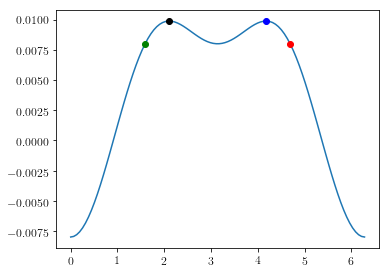

In [3]:
nLat = 1024
fSim = 0
nSims = 700
split_sims = np.arange(fSim, nSims+1, 100); print(split_sims)

filter_size = 0.
temp = 0.
phi0 = 2.3
lamb = 1.4
nCols = 2

nu = 2.*10**(-3)
V0 = 4.*nu
m2eff = lambda lam: V0 * (- 1. + lam**2)
lenLat = 250. / np.sqrt(V0); print('lenLat = ', lenLat)
phi_initial = np.pi
mask = 4*phi_initial

#normal = [phi_initial, np.mean([sim[1][0] for sim in all_data]), np.mean([sim[2][0] for sim in all_data]), V(phi_initial), np.mean([0.5*sim[1][0]**2 for sim in all_data])]
#normal = [phi_initial, 0, 0, V(phi_initial), 0]
normal = [phi_initial, 0]

nyq = nLat//2+1; spec = nyq; dx = lenLat/nLat; dk = 2.*np.pi/lenLat; dtout=dx; alpha=8.; print('dx, dk, spec ', dx, dk, spec)
light_cone = int(dtout/dx); print('light_cone = ', light_cone)

V = lambda phi, lamb: V0 * (-np.cos(phi)+0.5*lamb**2.*np.sin(phi)**2.)
dV = lambda phi, lamb: V0 * (np.sin(phi)+0.5*lamb**2.*np.sin(2.*phi))

far_right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x, lamb), bounds=[2*np.pi, 3*np.pi], method='bounded')
right_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x, lamb), bounds=[np.pi, 2*np.pi], method='bounded')
left_phi_at_V_max = sco.minimize_scalar(lambda x: -V(x, lamb), bounds=[0, np.pi], method='bounded')
phi_upper_bound = sco.fsolve(lambda x: V(x, lamb) - V(phi_initial, lamb), 5)[0]; print(phi_upper_bound)
phi_lower_bound = sco.fsolve(lambda x: V(x, lamb) - V(phi_initial, lamb), 1)[0]; print(phi_lower_bound)
plt.plot(np.linspace(0, 2*np.pi, 100), V(np.linspace(0, 2*np.pi, 100), lamb))
plt.plot(phi_upper_bound, V(phi_upper_bound, lamb), 'ro', phi_lower_bound, V(phi_lower_bound, lamb), 'go')
plt.plot(right_phi_at_V_max.x, V(right_phi_at_V_max.x, lamb), 'bo', left_phi_at_V_max.x, V(left_phi_at_V_max.x, lamb), 'ko')

In [4]:
titles = [r'$\phi(x)$', r'$\partial_t \phi(x)$', r'$|\nabla \phi(x)|^2$', r'$V(\phi(x))$']
plots_file = '/home/dpirvu/project/thermal_bubbles/plots/'
#pickle_file = '/home/dpirvu/project/pickle_location/thermal_bubbles/'
pickle_file = '/gpfs/dpirvu/thermal_bubbles/'

sim_location = lambda nL, tem, phi, lam, sim: '/gpfs/dpirvu/thermal_bubbles/bubbles_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
sim_suffix = lambda phi, lam, tem: '_for_temp{:.4f}'.format(temp)+'_phi0{:.4f}'.format(phi0)+'_lamb{:.4f}'.format(lamb)
bubbles_file = lambda phi, lam, tem, lSim, mSim: pickle_file+'bubbles_from_sim'+str(lSim)+'_up_to'+str(mSim)+sim_suffix(phi, lam, tem)+'.npy'
bubbles_file = lambda phi, lam, tem, lSim, mSim: pickle_file+'bubbles_from_sim'+str(lSim)+'_up_to'+str(mSim)+sim_suffix(phi, lam, tem)+'.npy'
posDataFile = lambda phi, lam, tem, lSim, mSim, mltpl, sigma: pickle_file+'positiveTargets_sims'+str(lSim)+'_to'+str(mSim)+'_multiplier'+str(mltpl)+'_filter{:.4f}'.format(sigma)+sim_suffix(phi, lam, tem)+'.npy'
negDataFile = lambda phi, lam, tem, lSim, mSim, mltpl, sigma: pickle_file+'negativeTargets_sims'+str(lSim)+'_to'+str(mSim)+'_multiplier'+str(mltpl)+'_filter{:.4f}'.format(sigma)+sim_suffix(phi, lam, tem)+'.npy'

bubbles_file = lambda phi, lam, tem, lSim, mSim: pickle_file+'bubbles_from_sim'+str(lSim)+'_up_to'+str(mSim)+sim_suffix(phi, lam, tem)+'.npy'
bubble_at_rest = lambda phi, lam, tem, sim: pickle_file+'rest_bubble_sim'+str(sim)+sim_suffix(phi, lam, tem)+'.npy'
average_bubble = lambda phi, lam, tem, lSim, mSim: pickle_file+'average_bubble_sims'+str(lSim)+'_to'+str(mSim)+sim_suffix(phi, lam, tem)+'.npy'
full_bubble_data = lambda phi, lam, tem, lSim, mSim: pickle_file+'rest_bubble_and_momentum_sims'+str(lSim)+'_to'+str(mSim)+sim_suffix(phi, lam, tem)+'.npy'
average_of_N_bubbles = lambda Nbubbles, phi, lam, tem: pickle_file+'average_of_'+str(Nbubbles)+'_bubbles'+sim_suffix(phi, lam, tem)+'.npy'

### VISUALISING SIMULATION DATA

In [5]:
def add_mask(field_slice, threshold):
    return field_slice * [0 if np.abs(i) > threshold else 1 for i in field_slice]

def find_slice_peaks(field_slice, peak_threshold):
    """ Finds x coordinate of peaks in masked field with mask applied at threshold. """
    peak_coord = signal.find_peaks(field_slice, height = peak_threshold)[0].tolist()
    if field_slice[-1] > peak_threshold and field_slice[0] > peak_threshold and field_slice[-1] != field_slice[0]:
        if field_slice[0] > field_slice[-1] and field_slice[0] > field_slice[1]:
            peak_coord.append(0)
        elif field_slice[0] < field_slice[-1] and field_slice[-1] > field_slice[-2]:
            peak_coord.append(len(field_slice)-1) # this minds potential boundary discontinuities
    peak_heights = [field_slice[coord] for coord in peak_coord]
    return peak_coord, field_slice.tolist().index(np.max(peak_heights))

def truncateNum(num, decimal_places):
    StrNum = str(num)
    p = StrNum.find(".") + 1 + decimal_places
    return float(StrNum[0:p])

def time_at_fraction(bubble, frac, limit):
    T, N = len(bubble), len(bubble[0])
    right_phi_x = [np.sum([1 for x in slice if mask > x >= limit]) for slice in bubble]
    time_list = [t if (right_phi_x[t] <= N*frac) else 0 for t in range(T)]
    return next((t for t in time_list[::-1] if t != 0), 0)

def time_at_size(bubble, size, limit):
    T, N = len(bubble), len(bubble[0])
    right_phi_x = [np.sum([1 for x in slice if mask > x >= limit]) for slice in bubble]
    time_list = [t if (right_phi_x[t] <= size) else 0 for t in range(T)]
    return next((t for t in time_list[::-1] if t != 0), T-1)

def center_bubble(bubble):
    limit = np.floor(phi_upper_bound)
    tdecap = time_at_fraction(bubble[0], 0.85, limit)
    bubble = [bubble[col][:tdecap] for col in range(len(bubble))]
    bubble0 = bubble[0]
    #truncate bubble where it expands relativistically
    T, N = len(bubble0), len(bubble0[0])

    #rotate bubble such that the relativistic bit is perfectly centered
    fld = gaussian_filter1d(bubble0[-1], sigma=1, mode='wrap')
    vals = [x if (fld[x] > limit and fld[x+1] > limit) else 0 for x in range(N-1)]
    bubbles = [list(g) for k, g in groupby(vals, lambda x: x != 0) if k]
    
    if len(bubbles) > 1:
        maxi, imax, keep = 0, bubbles[0][0], 0
        for i in range(len(bubbles)-1):
            maxi = np.abs(bubbles[i+1][0]-bubbles[i][-1])
            if maxi > imax:
                imax = maxi
                keep = i
        first_zero = int(np.mean([bubbles[keep][-1], bubbles[keep+1][0]]))
        bubble = np.asarray([[np.roll(slice, -first_zero) for slice in bubble[col]] for col in range(len(bubble))])
    else:
        first_zero = int(bubbles[0][0]/2.)
        bubble = np.asarray([[np.roll(slice, -first_zero) for slice in bubble[col]] for col in range(len(bubble))])
#        bubble = np.asarray([bubble[col] for col in range(len(bubble))])

    # check which sides the COM travels
    bubble0 = bubble[0]
    tcheck = time_at_fraction(bubble0, 0.015, limit)
    fld = [gaussian_filter1d(slice, sigma=1, mode='wrap') for slice in bubble0[tcheck-100:tcheck:2]]
    tv = [np.nanmean([x for x in range(N) if fld[t][x] > limit]) for t in range(len(fld))]
    decr = np.sum([1 for i, j in zip(tv, tv[1::]) if i > j])
    incr = np.sum([1 for i, j in zip(tv, tv[1::]) if i < j])
    return bubble, decr - incr #np.nanmean(tv) - N//2

def multiply_bubble(bubble, dir, fold):
    bubble0 = bubble[0]
    T, N = len(bubble0), len(bubble0[0])
    bubble = [np.tile(bubble[col], fold) for col in range(len(bubble))] # multiplies bubbles so tail is kept without pbc
    TT, NN = len(bubble[0]), len(bubble[0][0])
    for t in range(TT):
        a, b = int((TT-t)*light_cone) + N, int((TT-t)*light_cone/2) - N//4
        x1, x2 = np.arange(a, NN), np.arange(b)
        if dir < 0:
            x1, x2 = x1 - a, x2 - (b-NN)
        for x in np.append(x1, x2):
            if 0 <= x < NN:
                bubble[0][t][x] = phi_initial
    return np.asarray(bubble)

In [6]:
list_temp = [0., 0.1, 0.2]
temp = list_temp[1]

importall = list(chain(np.load(bubbles_file(phi0, lamb, temp, lSim, mSim)) for lSim, mSim in zip(split_sims, split_sims[1:])))
all_data, sims_to_keep = np.asarray([importall[i][0] for i in range(len(importall))]), np.asarray([importall[i][1] for i in range(len(importall))])
all_data = [item for sublist in all_data for item in sublist]
sims_to_keep = [item for sublist in sims_to_keep for item in sublist]
print(sims_to_keep)
print(np.shape(all_data))

[41, 91, 172, 198, 254, 382, 454, 504, 553, 570, 628, 655, 683]
(13, 2)


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


0


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: Mean of empty slice


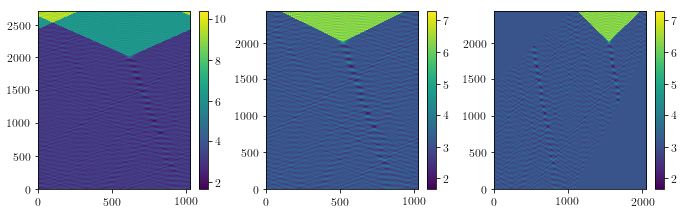

1


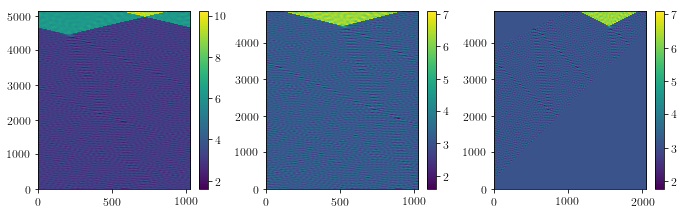

2


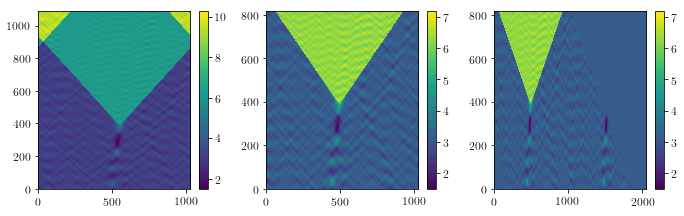

3


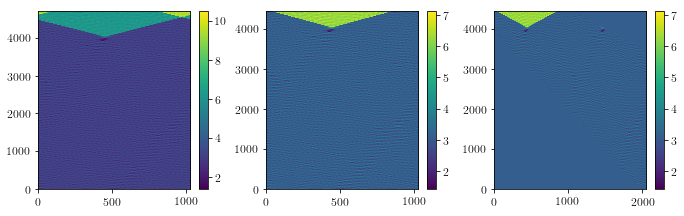

4


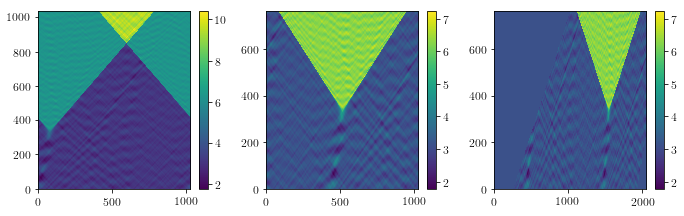

5


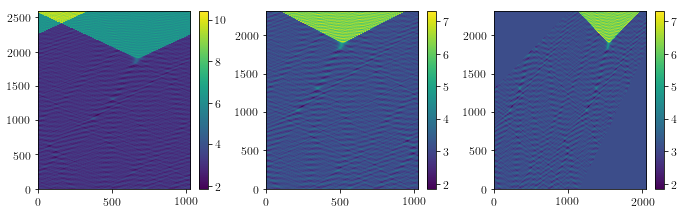

6


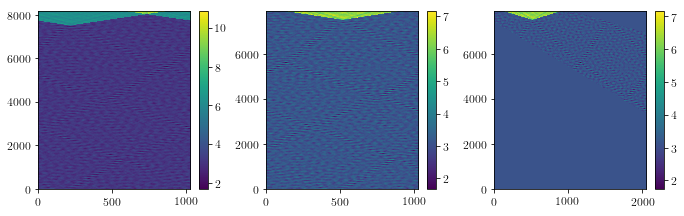

7


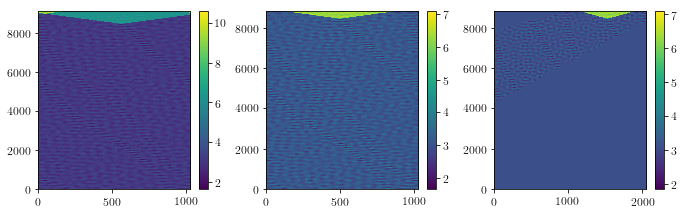

8


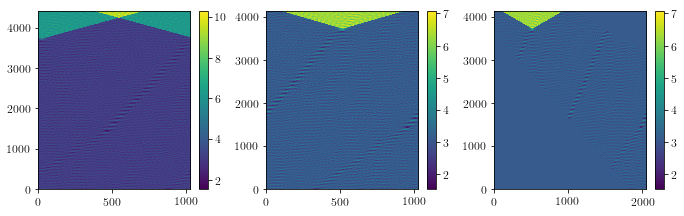

9


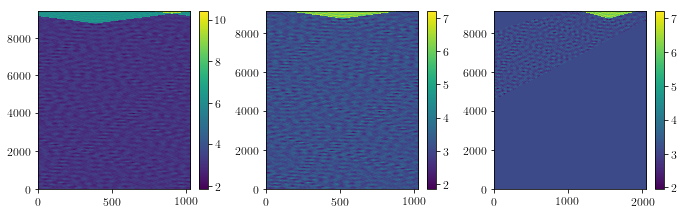

10


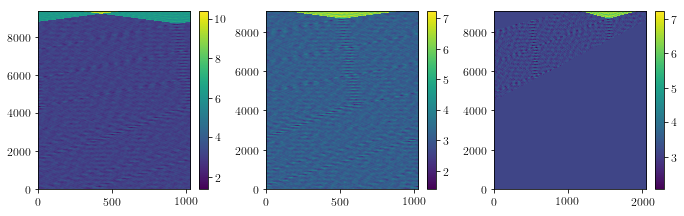

11


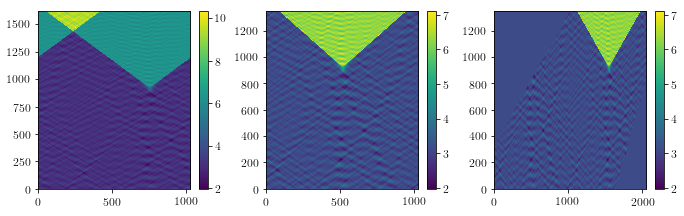

12


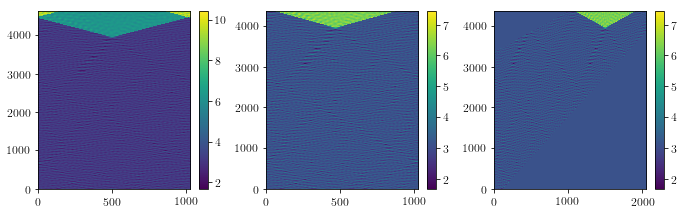

In [7]:
if True:
    for sim in range(len(all_data))[::]:
        print(sim)
        col = 0
        simulation = all_data[sim]
        centered, dir = center_bubble(simulation)
        mult = multiply_bubble(centered, dir, 2)
        fig, ax = plt.subplots(1, 3, figsize = (12, 3))
        im0 = ax[0].imshow(simulation[col], aspect='auto', interpolation='none', origin='lower')
        im1 = ax[1].imshow(centered[col], aspect='auto', interpolation='none', origin='lower')
        im2 = ax[2].imshow(mult[col], aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im0, ax = ax[0]); clb = plt.colorbar(im1, ax = ax[1]); clb = plt.colorbar(im2, ax = ax[2]); plt.show()

In [8]:
rapidity = lambda vel: np.arctanh(vel)
gamma = lambda vel: (1.-vel**2.)**-0.5
tanh_pos = lambda x, r0L, r0R, dr, vL, vR : ( np.tanh( (x - r0L)/(dr/gamma(vL)) ) + np.tanh( (r0R - x)/(dr/gamma(vR)) ) ) * np.pi/2 + np.pi
tanh_neg = lambda x, r0L, r0R, dr, vL, vR : - ( np.tanh( (x - r0L)/(dr/gamma(vL)) ) + np.tanh( (r0R - x)/(dr/gamma(vR)) ) ) * np.pi/2 + np.pi
hyperbola1 = lambda t, a, b, c: np.sqrt(c+(t-b)**2.)+a
hyperbola2 = lambda t, d, e, f: -np.sqrt(f+(t-e)**2.)+d

def tanh_fit(bubble_slice, axis, prior):
#    plt.plot(axis, bubble_slice, 'ro', axis, [tanh(r, *best_tanh) for r in axis], 'g'); plt.show()
    bounds = ((axis[0], 0, 0, 0, 0), (0, axis[-1], axis[-1], 1, 1))
    if prior is not None:
        if np.mean(bubble_slice) > phi_initial:
            return sco.curve_fit(tanh_pos, axis, bubble_slice, p0=prior, bounds=bounds)[0]
        else:
            return sco.curve_fit(tanh_neg, axis, bubble_slice, p0=prior, bounds=bounds)[0]            
    else:
        if np.mean(bubble_slice) > phi_initial:
            return sco.curve_fit(tanh_pos, axis, bubble_slice, bounds=bounds)[0]
        else:
            return sco.curve_fit(tanh_neg, axis, bubble_slice, bounds=bounds)[0]

def hypfit_test(tt, rr, qq): # no parameters in common between left and right wall for hyperbolic curve fit
    try:
        if rr[0] <= rr[-1]:
            fit1, pcov1 = sco.curve_fit(hyperbola1, tt, rr, p0 = (min(rr), tt[rr.tolist().index(min(rr))], 1e4))
            fit2, pcov2 = sco.curve_fit(hyperbola2, tt, qq, p0 = (max(qq), tt[qq.tolist().index(max(qq))], 1e4))
        else:
            fit1, pcov1 = sco.curve_fit(hyperbola2, tt, rr, p0 = (max(rr), tt[rr.tolist().index(max(rr))], 1e4))
            fit2, pcov2 = sco.curve_fit(hyperbola1, tt, qq, p0 = (min(qq), tt[qq.tolist().index(min(qq))], 1e4))
        return True
    except (RuntimeError, TypeError):
        return False
    
def hypfit(tt, rr, qq): # no parameters in common between left and right wall for hyperbolic curve fit
    if rr[0] <= rr[-1]:
        fit1, pcov1 = sco.curve_fit(hyperbola1, tt, rr, p0 = (min(rr), tt[rr.tolist().index(min(rr))], 1e4))
        fit2, pcov2 = sco.curve_fit(hyperbola2, tt, qq, p0 = (max(qq), tt[qq.tolist().index(max(qq))], 1e4))
        traj1, traj2 = hyperbola1(tt, *fit1), hyperbola2(tt, *fit2)
    else:
        fit1, pcov1 = sco.curve_fit(hyperbola2, tt, rr, p0 = (max(rr), tt[rr.tolist().index(max(rr))], 1e4))
        fit2, pcov2 = sco.curve_fit(hyperbola1, tt, qq, p0 = (min(qq), tt[qq.tolist().index(min(qq))], 1e4))
        traj1, traj2 = hyperbola2(tt, *fit1), hyperbola1(tt, *fit2)
#    print('hyperbolic trajectories fit: ', fit1, fit2)
#    plt.plot(rr, tt, 'g-', qq, tt, 'r-', traj1, tt, 'y:', traj2, tt, 'b:') # plot the equation using the fitted parameters
    return tt, traj1, traj2

def get_velocities(tt, rrwallfit, llwallfit):
    #uu = wall travelling along with the com; vv = wall travelling against the com; aa = centre of mass velocity; bb = instantaneous velocity of wall
    uu = intp.splev(tt, intp.splrep(tt, rrwallfit), der=1)
    vv = intp.splev(tt, intp.splrep(tt, llwallfit), der=1)
    for i in range(len(uu)):
        if str(uu[i])=='nan' or np.abs(uu[i])>1. : uu[i] = - np.sign(vv[-1])*0.999999
        if str(vv[i])=='nan' or np.abs(vv[i])>1. : vv[i] = - np.sign(uu[-1])*0.999999

    aa = ( 1 + uu*vv - np.sqrt( (-1 + uu**2)*(-1 + vv**2))) / ( uu + vv)
    bb = (-1 + uu*vv + np.sqrt( (-1 + uu**2)*(-1 + vv**2))) / (-uu + vv)
    return uu, vv, aa, bb

def velocity(bubble, bool1, bool2):
    T, N = len(bubble), len(bubble[0])
    limit = phi_upper_bound #phi_upper_bound - 0.95*np.abs(phi_upper_bound-np.floor(phi_upper_bound))
    err = 0

    # find where fit can begin
    window = int(N//10)
    if window > 100: window = 100

    tf = T-1
    endSlice = [i for i in range(N) if bubble[tf][i] > limit]
    if len(endSlice) == 0:
        return 'next'
    while endSlice[0] - window < 0 or endSlice[-1] + window >= N:
        tf -= 2
        endSlice = [i for i in range(N) if bubble[tf][i] > limit]
        if len(endSlice) == 0:
            return 'next'

    data_list = []
    prior = None
    for t in range(tf, 0, -1):
        if len(data_list) == 0:
            peaks = endSlice
            target = int(np.round(np.nanmean(peaks)))
            coord_list = np.arange(peaks[0] - window, peaks[-1] + window)
        else:
            xrange = np.arange(data_list[-1][0]-window, data_list[-1][0]+window+1)
            if all(0 <= i < N for i in xrange) and any(np.cos(bubble[t][i]) > np.cos(limit) for i in xrange):
                peaks = [i for i in xrange if np.cos(bubble[t][i]) > np.cos(limit)]
            else:
                break
            target = int(np.round(np.nanmean(peaks)))
            coord_list = np.arange(target - int(np.round(np.abs(data_list[-1][1]))) - window, target + int(np.round(np.abs(data_list[-1][2]))) + window)

        coords = np.asarray([(bubble[t][i%N], int(i-target)) for i in coord_list])
        if err < 5:
            try:
                r0L, r0R, dr, vL, vR = tanh_fit(coords[:,0], coords[:,1], prior)
                prior = None#r0L, r0R, dr, vL, vR
                data_list.append([target, r0L, r0R, int(t)])
            except (RuntimeError, ValueError, TypeError):
                prior = None
                data_list.append([target, r0L + np.sign(data_list[-1][1]-data_list[0][1])*light_cone*(T/N), r0R + np.sign(data_list[-1][2]-data_list[0][2])*light_cone*(T/N), int(t)])
                err += 1
        else:
            break
    data_list = np.asarray(data_list[::-1])
    targets, r0Ls, r0Rs, time_list = data_list[:,0], data_list[:,1], data_list[:,2], data_list[:,-1]

    # get direction of bubble
    radius_diff = np.mean([np.abs(data_list[i,1]) - np.abs(data_list[i,2]) for i in range(len(data_list)//4)])
    if radius_diff > 0:  # if average difference in radius is positive then left radius is on average higher than right radius i.e. bubble travels to the right
        rr, ll = targets + r0Rs, targets + r0Ls
    else:
        rr, ll = targets + r0Ls, targets + r0Rs

    if bool1:
        fig, ax0 = plt.subplots(1, 1, figsize = (5, 4))
        ax0.plot(rr, time_list, 'b', ll, time_list, 'y', linewidth='3')
        ax0.set_xlabel('x'); ax0.set_ylabel('t'); plt.show()

    # get velocities from derivative of best fit to wall trajectory
    trunc = 0
    # save copies
    time_list_copy, rr_copy, ll_copy = time_list, rr, ll
    # as lons as it needs..
    while(True):
        # try to fit walls
        if hypfit_test(time_list_copy, rr_copy, ll_copy):
            time_list, rrwallfit, llwallfit = hypfit(time_list_copy, rr_copy, ll_copy)
            uu,vv,aa,bb = get_velocities(time_list, rrwallfit, llwallfit)
            break
        # if fit fails, shorten walls
        else:
            trunc += 25
            if len(time_list_copy) > 100:
                time_list_copy, rr_copy, ll_copy = time_list_copy[trunc::], rr_copy[trunc::], ll_copy[trunc::]
            else:
                return 'next'
            continue

    if bool2:
        fig, [ax0, ax1] = plt.subplots(1, 2, figsize = (15, 4))
        ax0.plot(rr[-len(time_list):], time_list, 'b', ll[-len(time_list):], time_list, 'y', rrwallfit, time_list, 'r:', llwallfit, time_list, 'r:', linewidth='3')
        ax0.set_xlabel('x'); ax0.set_ylabel('t')
        ax1.plot(time_list, uu, 'b:', time_list, vv, 'y:')
        ax1.plot(time_list, aa, 'r', label=r'v COM')
        ax1.plot(time_list, bb, 'g', label=r'v walls')
        ax1.axhline(0, color='darkgray', ls=':')
        ax1.set_xlabel('t'); ax1.set_ylabel('v(t)'); ax1.legend(); plt.show()

    list = np.abs(aa - bb)
    if any(str(i) != 'nan' for i in list):
        return -aa[list.tolist().index(np.nanmin(list))]
    else:
        return 'next'

In [60]:
fold = lambda beta: 3 if np.abs(beta) > 0.8 else 2
add_velocities = lambda v1, v2: (v1 + v2) / (1. + v1*v2)

def cut_out_bubble(bubble):
    bubble = np.asarray(bubble)
    bubble0 = bubble[0]
    limit = phi_initial
    T, N = np.shape(bubble0)
    ext = max(100, int(N//8))

    xmin = max(0, next((i for i in range(N) if bubble0[-1,i] > limit), 0) - ext)
    xmax = min(N, next((i for i in range(N)[::-1] if bubble0[-1,i] > limit), N-1) + ext)

    tmin = 0
    while len([i for i in bubble0[tmin, xmin:xmax] if (limit < i and i < mask)]) < ext and tmin < T:
        tmin += 1
    return bubble[:, tmin:T, xmin:xmax]

def center_bubble_again(bubble, beta):
    bubble0 = np.asarray(bubble[0])
    T, N = np.shape(bubble0)
    ext = max(100, int(N//8))

    if beta > 0.:
        x1, peaks = 0, np.asarray([(0, phi_initial)])
        while np.cos(np.nanmean(peaks[:,1])) < np.cos(3.18) and x1 < N:
            peaks = np.asarray([(ii, jj) for ii, jj in enumerate(bubble0[:, x1]) if jj < mask])
            x1 += 1
            if len(peaks) == 0:
                print('Bubble out of frame.')
                return 'next'
        print('T, N = ', T, N)
        tmax = int(peaks[-1,0]); print('tmax = ', tmax)
        xmin = max(0, x1 - ext); print('xmin = ', xmin)
        xmax = next((i for i in range(xmin, N)[::-1] if (mask > bubble0[tmax,i] and bubble0[tmax,i] > phi_initial)), N); print('xmax = ', xmax)
    else:
        x1, peaks = N-1, np.asarray([(0, phi_initial)])
        while np.cos(np.nanmean(peaks[:,1])) < np.cos(3.18) and x1 > 0:
            peaks = np.asarray([(ii, jj) for ii, jj in enumerate(bubble0[:, x1]) if jj < mask])
            x1 -= 1
            if len(peaks) == 0:
                print('Bubble out of frame.')
                return 'next'
        print('T, N = ', T, N)
        tmax = int(peaks[-1,0]); print('tmax = ', tmax)
        xmax = min(N, x1 + ext); print('xmax = ', xmax)
        xmin = next((i for i in range(xmax) if (mask > bubble0[tmax,i] and bubble0[tmax,i] > phi_initial)), 0); print('xmin = ', xmin)

    tmin = 0
    while len([i for i in bubble0[tmin, xmin:xmax] if (phi_initial < i and i < mask)]) < ext and tmin < tmax:
        tmin += 1
    print('tmin = ', tmin)
    return [[[bubble[col][t][x] if bubble[col][t][x] != mask else normal[col] for x in range(xmin, xmax)] for t in range(tmin, tmax)] for col in range(len(bubble))]

def interpolate_bubble(bubble, res):
    T, N = len(bubble), len(bubble[0])
    bubble = np.asarray(bubble)
    listt, listx = np.arange(T), np.arange(N)
    tt, xx = np.meshgrid(listt, listx)
    func = intp.interp2d(listt, listx, bubble[tt, xx], kind = 'quintic')
    listT, listX = np.linspace(0, T, res*T), np.linspace(0, N, res*N)
    return func(listT, listX).T

def boost_bubble(bubble, vCOM, res):
    print('Boost velocity factor: ', vCOM)
    boost = lambda vCOM, ga, x, t: ga * (x - vCOM*t)

    bubble0 = np.asarray(bubble[0])
    T, N = np.shape(bubble0)
    limit = phi_upper_bound
    ga = gamma(vCOM)

    t0 = int(time_at_size(bubble0, 50, limit)) # arbitrary choice of bubble centre
    x0 = int(np.mean([i for i in range(N) if mask > bubble0[t0, i] > limit]))

    print('boost centre t0, x0: ', t0, x0)
    T0, X0 = boost(vCOM, ga, t0, x0), boost(vCOM, ga, x0, t0)
    deltaT, deltaX = T0-t0, X0-x0

    bubble = [interpolate_bubble(bubble[col], res) for col in range(len(bubble))]; print('shape interpolated bubble:', np.shape(bubble))
    new_bubble = [[[mask for x in range(N)] for t in range(T)] for col in range(len(bubble))]

    for t in range(T):
        for x in range(N):
            tt = int((boost(vCOM, ga, t, x) + np.sign(T/2.-t0) * deltaT)*res)
            xx = int((boost(vCOM, ga, x, t) + np.sign(N/2.-x0) * deltaX)*res)
            if (T*res > tt >= 0 and N*res > xx >= 0):
                for col in range(len(bubble)):
                    new_bubble[col][t][x] = bubble[col][tt][xx]
    return new_bubble

In [63]:
def the_whole_shebang(resolution, saveF):
    for sim in range(len(all_data))[::-1]:
        exists = os.path.exists(bubble_at_rest(phi0, lamb, temp, sims_to_keep[sim]))
        #if sims_to_keep[sim] >= 0 and not exists:
        if True:

            print('On to simulation ', sim)
            bubble = all_data[sim]
            bubble, dir = center_bubble(bubble)
            beta = velocity(bubble[0], bool1=False, bool2=True)
            if beta == 'next':
                print('sim '+str(sim)+' skipped')
                continue
            elif np.abs(beta) > 0.9:
                beta = np.sign(beta)*0.9

            bubble = multiply_bubble(bubble, dir, fold(beta))
            fig = plt.figure(figsize=(5,5))
            plt.imshow(bubble[0], aspect='auto', interpolation='none', origin='lower')
            plt.title('original view'); plt.show()
    
            vtotal, bool1, bool2 = 0, True, False
            while np.abs(beta) > 0.1:
                bool2 = True

                bubble = boost_bubble(bubble, beta, resolution)
                fig = plt.figure(figsize=(5,5))
                plt.imshow(bubble[0], aspect='auto', interpolation='none', origin='lower')
                plt.title('boosted view'); plt.show()
                
                bubble = center_bubble_again(bubble, beta)
                if bubble == 'next':
                    print('sim '+str(sim)+' interrupted')
                    bool1 = False
                    break
                else:
                    fig = plt.figure(figsize=(5,5))
                    plt.imshow(bubble[0], aspect='auto', interpolation='none', origin='lower')
                    plt.title('re-centered view'); plt.show()                    

                prebeta = beta
                vtotal = add_velocities(vtotal, beta)
                print('step done ', beta)

                min_bubble = cut_out_bubble(bubble)
                fig = plt.figure(figsize=(5,5))
                plt.imshow(min_bubble[0], aspect='auto', interpolation='none', origin='lower')
                plt.title('final view'); plt.show()

                beta = velocity(min_bubble[0], bool1=False, bool2=True)
                if beta == 'next':
                    print('sim '+str(sim)+' interrupted')
                    if np.abs(prebeta) >= 0.8:
                        bool1 = False
                    break
                elif np.abs(beta) > 0.9:
                    beta = np.sign(beta)*0.9

            if not bool2:
                if np.abs(beta) > 0:
                    min_bubble = cut_out_bubble(bubble)
                    vtotal = beta
                    bool2 = True

            if bool1 and bool2:
                print('sim', sim, 'total vel ', vtotal)
                if saveF:
                    np.save(bubble_at_rest(phi0, lamb, temp, sims_to_keep[sim]), [min_bubble, vtotal])
                    print('Bubble saved!')
    return

On to simulation  12


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: Mean of empty slice
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


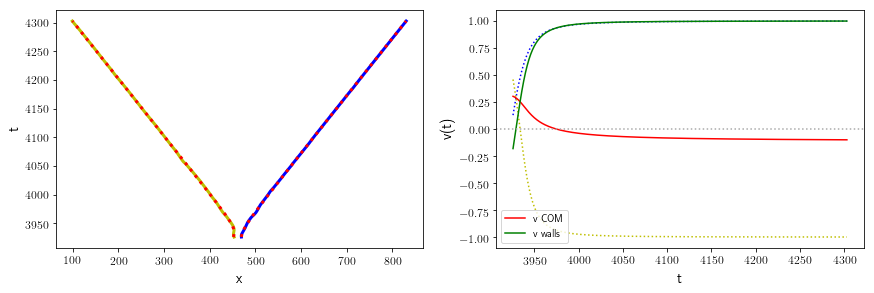

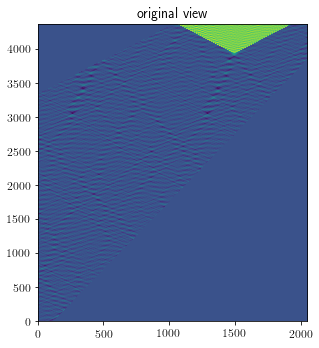

Boost velocity factor:  -0.2524641478062389
boost centre t0, x0:  3960 1488
shape interpolated bubble: (2, 8744, 4096)


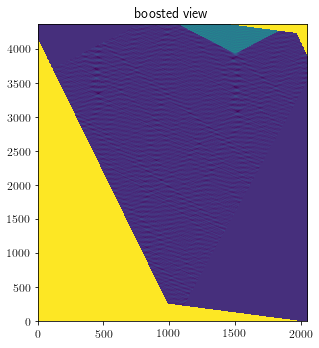

T, N =  4372 2048
tmax =  4282
xmax =  2043
xmin =  4
tmin =  194


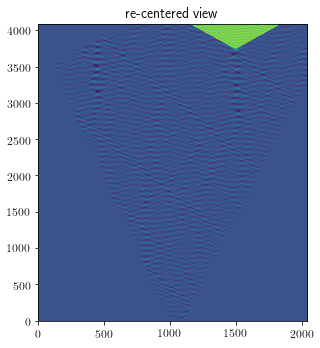

step done  -0.2524641478062389


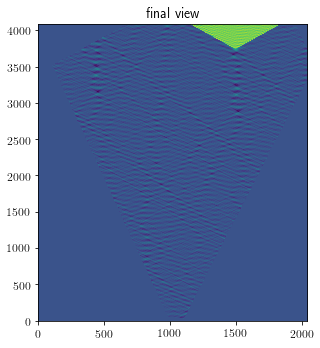

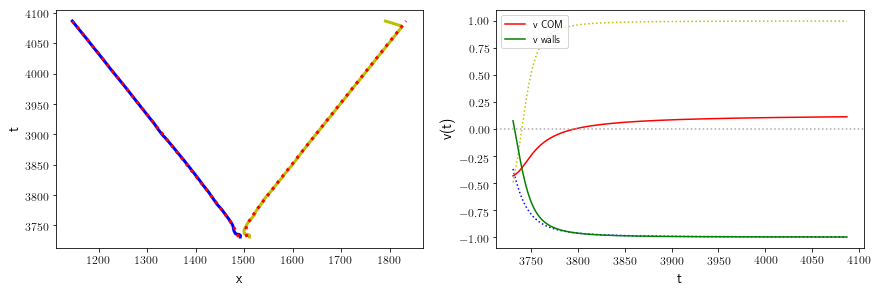

Boost velocity factor:  0.3635777663169557
boost centre t0, x0:  3764 1491
shape interpolated bubble: (2, 8176, 4078)


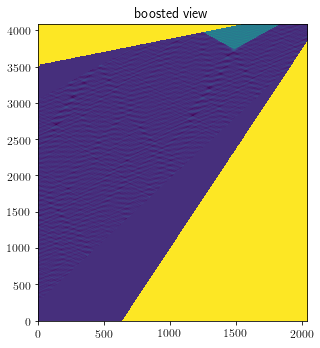

T, N =  4088 2039
tmax =  3984
xmin =  1013
xmax =  2038
tmin =  2202


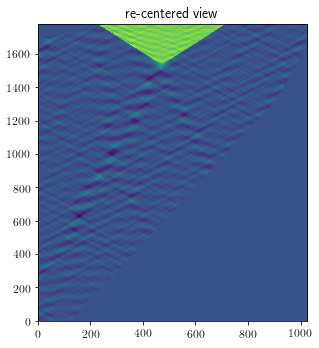

step done  0.3635777663169557


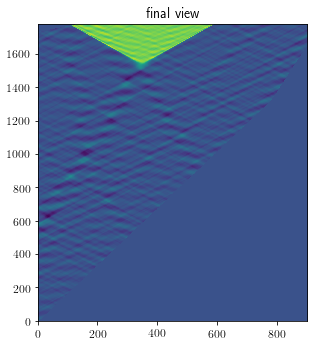

/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


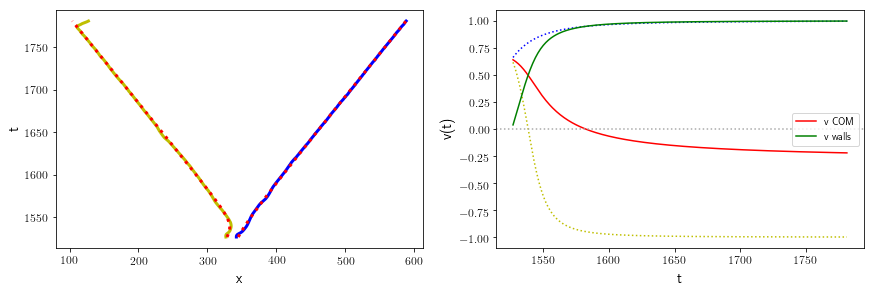

Boost velocity factor:  -0.5042882960499229
boost centre t0, x0:  1560 469
shape interpolated bubble: (2, 3564, 2050)


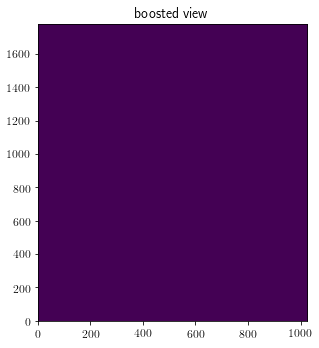

Bubble out of frame.
sim 12 interrupted
On to simulation  11


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: Mean of empty slice
/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


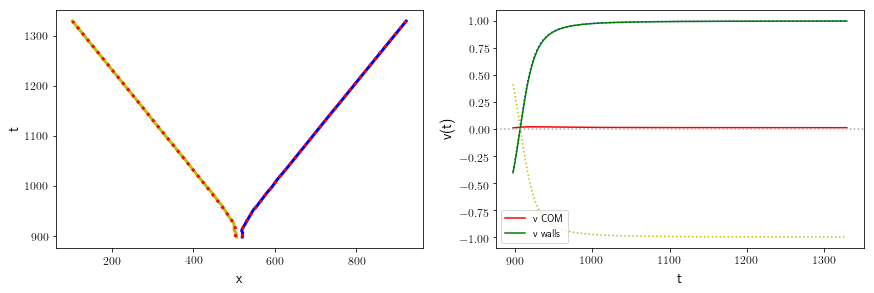

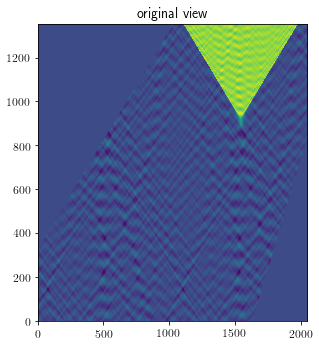

sim 11 total vel  -0.01756095097104319
Bubble saved!
On to simulation  10


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


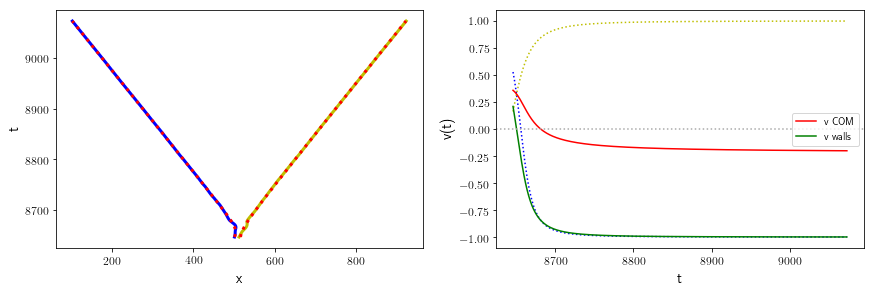

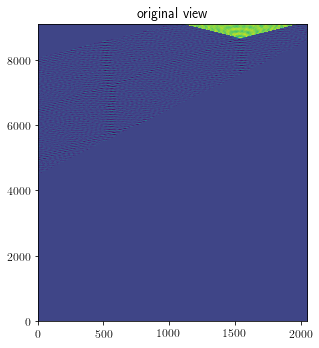

Boost velocity factor:  -0.3576613424319485
boost centre t0, x0:  8682 1534
shape interpolated bubble: (2, 18196, 4096)


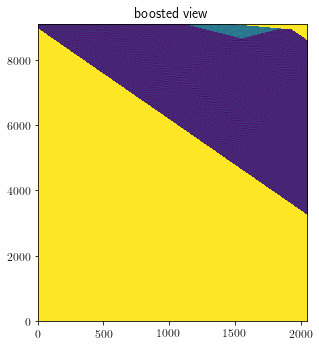

T, N =  9098 2048
tmax =  8976
xmax =  2048
xmin =  0
tmin =  5132


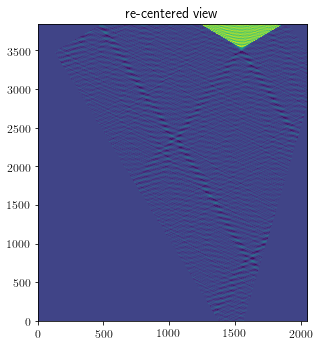

step done  -0.3576613424319485


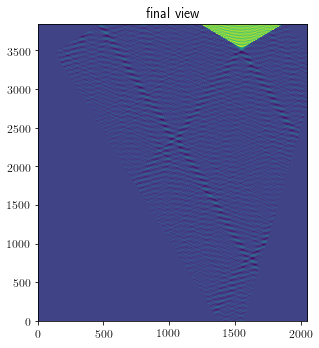

sim 10 interrupted
sim 10 total vel  -0.3576613424319485
Bubble saved!
On to simulation  9


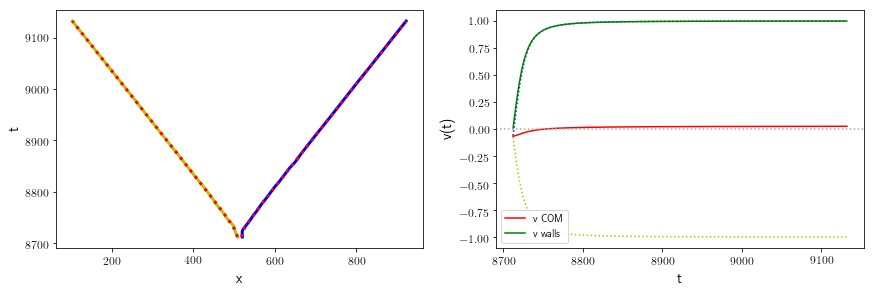

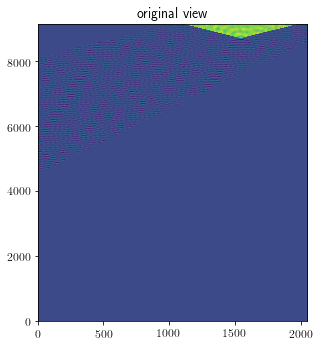

sim 9 total vel  0.06741474301026111
Bubble saved!
On to simulation  8


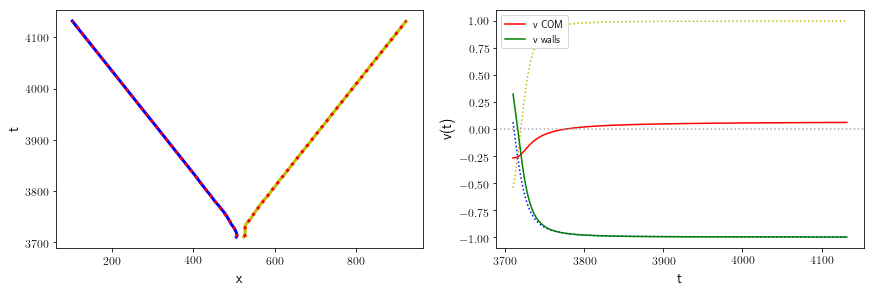

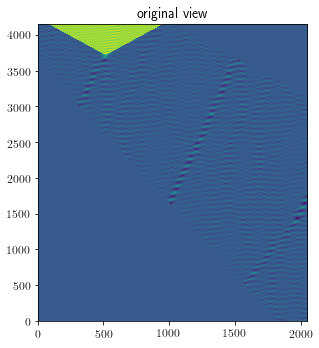

Boost velocity factor:  0.234582333072146
boost centre t0, x0:  3743 512
shape interpolated bubble: (2, 8314, 4096)


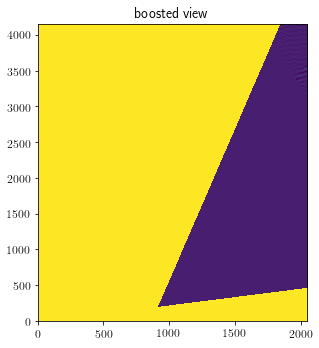

Bubble out of frame.
sim 8 interrupted
On to simulation  7


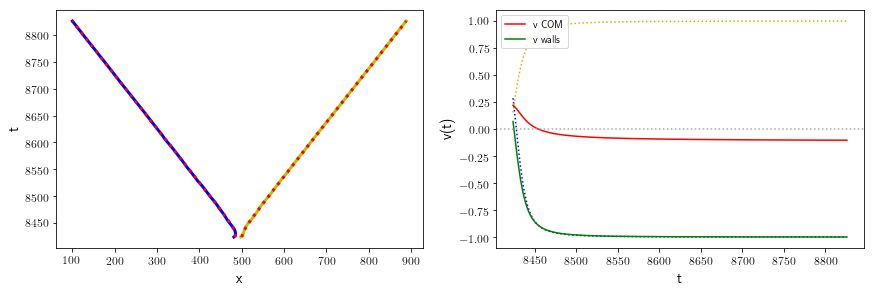

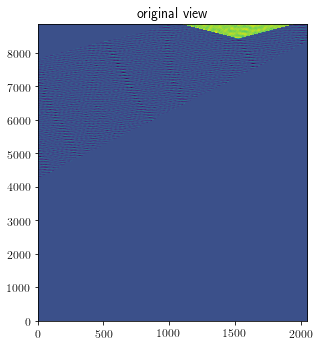

Boost velocity factor:  -0.22036382355916295
boost centre t0, x0:  8453 1517
shape interpolated bubble: (2, 17726, 4096)


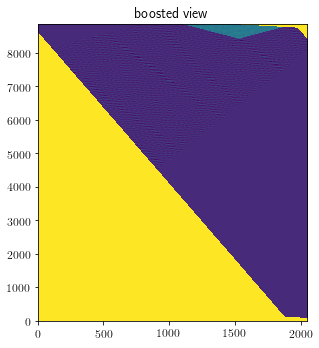

T, N =  8863 2048
tmax =  8794
xmax =  2039
xmin =  1
tmin =  2875


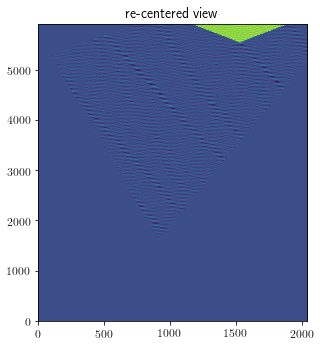

step done  -0.22036382355916295


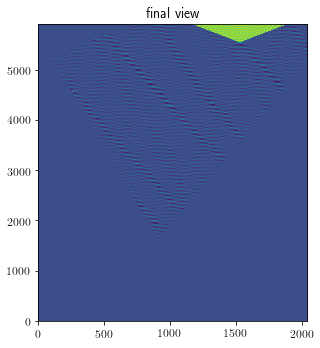

IndexError: index 0 is out of bounds for axis 0 with size 0

In [64]:
#the_whole_shebang(2, saveF = True)
the_whole_shebang(2, saveF = True)

### Average bubble

In [65]:
def cut_out_coordinates(bubble0):
    T, N = len(bubble0), len(bubble0[0])
    limit = phi_upper_bound
    size = 30 # do not change

    t0 = int(time_at_size(bubble0, size, limit)) # arbitrary choice of bubble centre
    x0 = int(np.nanmean([i for i in range(N) if mask > bubble0[t0][i] > limit]))
    xstdev = np.nanvar([np.nanmean([x for x in range(N) if bubble0[t][x] >= limit]) for t in range(t0-size, t0+size, 2)])
    if xstdev > size: return None
    
#    fig = plt.figure(figsize=(4,4))
#    plt.plot(x0, t0, 'bo')
#    plt.imshow(np.asarray(bubble0), aspect='auto', interpolation='none', origin='lower')
#    plt.xlim(x0-300, x0+300); plt.ylim(t0-300, t0+300); plt.show()

    ex1, ex2, ex3, ex4 = np.arange(t0)[::-1], np.arange(t0, T), np.arange(x0)[::-1], np.arange(x0, N)
    return ex1[:800], ex2[:300], ex3[:300], ex4[:300]

def stack_bubbles(bubble_data, bool1, bool2):
    extent_list, bad_bubbles = [], []
    print('bad bubbles pictured below if bool1 = True')

    for sim in range(len(bubble_data)):
        coords = cut_out_coordinates(bubble_data[sim][0])
        if coords is not None:
            extent_list.append(coords)
        else:
            bad_bubbles.append(sim)
            if bool1:
                fig, ax = plt.subplots(1, 1, figsize=(6, 5))
                im = ax.imshow(bubble_data[sim][0], aspect='auto', interpolation='none', origin='lower')
                clb = plt.colorbar(im, ax = ax); plt.show()

    bubble_data = np.asarray([bubble_data[i] for i in range(len(bubble_data)) if i not in bad_bubbles])
    print('Number of good bubbles remaining: ', len(bubble_data), ' pictured below if bool2 = True')
    if bool2:
        for sim in range(len(bubble_data)):
            fig, ax = plt.subplots(1, 1, figsize=(6, 5))
            im = ax.imshow(np.asarray(bubble_data[sim][0])[extent_list[sim][0][-1]:extent_list[sim][1][-1], extent_list[sim][2][-1]:extent_list[sim][3][-1]], aspect='auto', interpolation='none', origin='lower')
            clb = plt.colorbar(im, ax = ax); plt.show()

#    for sim in range(len(bubble_data)):
#        bubble_data[sim].append([0.5*np.asarray(i)**2 for i in bubble_data[sim][1]])
    NSims, NCols = np.shape(bubble_data)[:2]
    print(NSims, NCols)

    extent_list = np.asarray(extent_list)
    uper_right_bubble_list = [[[[bubble_data[sim,col][t][x] for t in extent_list[:,0][sim]] for x in extent_list[:,2][sim]] for sim in range(NSims)] for col in range(NCols)]
    upper_left_bubble_list = [[[[bubble_data[sim,col][t][x] for t in extent_list[:,0][sim]] for x in extent_list[:,3][sim]] for sim in range(NSims)] for col in range(NCols)]
    lower_right_bubble_list = [[[[bubble_data[sim,col][t][x] for t in extent_list[:,1][sim]] for x in extent_list[:,2][sim]] for sim in range(NSims)] for col in range(NCols)]
    lower_left_bubble_list = [[[[bubble_data[sim,col][t][x] for t in extent_list[:,1][sim]] for x in extent_list[:,3][sim]] for sim in range(NSims)] for col in range(NCols)]
    return [uper_right_bubble_list, upper_left_bubble_list, lower_right_bubble_list, lower_left_bubble_list], bad_bubbles

def average_bubble_func(stacked_bubble_data):
    uper_right_bubble_list, upper_left_bubble_list, lower_right_bubble_list, lower_left_bubble_list = stacked_bubble_data
    nCols = len(uper_right_bubble_list)
    print(nCols)

    av_mat, av_err_mat = [], []
    for col in range(nCols):
        average_matrix, average_error_matrix = [[],[],[],[]], [[],[],[],[]]
        coord_lists = [uper_right_bubble_list[col], upper_left_bubble_list[col], lower_right_bubble_list[col], lower_left_bubble_list[col]]

        for i in range(4): #for each quadrant
            max_lines, max_cols = 0, 0
            for simulation in coord_lists[i]:
                if len(simulation) > max_lines:
                    max_lines = len(simulation)
                if len(simulation[0]) > max_cols:
                    max_cols = len(simulation[0])

            for line in range(max_lines):
                average_matrix[i].append([normal[col] for nn in range(max_cols)])
                average_error_matrix[i].append([0. for nn in range(max_cols)])

            for num_line in range(max_lines):
                for num_col in range(max_cols):
                    meas = []
                    for simulation in coord_lists[i]:
                        if len(simulation) > num_line and len(simulation[0]) > num_col:
                            meas.append(simulation[num_line][num_col])

                    average_matrix[i][num_line][num_col] = np.mean(meas)
                    if len(meas) >= 2:
                        average_error_matrix[i][num_line][num_col] = stat.stdev(meas)/len(meas)
        av_mat.append(average_matrix)
        av_err_mat.append(average_error_matrix)

    whole_bubbles = []
    for av_bub in [av_mat, av_err_mat]:
        whole_bubbles.append([])
        for col in range(nCols):
            top = np.concatenate((np.flip(np.asarray(np.flip(av_bub[col][0],1)).transpose(),1), np.flip(np.asarray(av_bub[col][1]).transpose(),0)), axis=1)
            bottom = np.concatenate((np.flip(np.asarray(av_bub[col][2]).transpose(),1), np.flip(np.asarray(np.flip(av_bub[col][3],0)).transpose(),1)), axis=1)
            whole_bubbles[-1].append(np.concatenate((top, bottom), axis=0))
    return np.asarray(whole_bubbles)

def truncated_bubbles_stacked(stacked_bubble_data):
    uper_right_bubble_list, upper_left_bubble_list, lower_right_bubble_list, lower_left_bubble_list = stacked_bubble_data
    nCols = len(uper_right_bubble_list)

    whole_bubbles = []
    for sim in range(len(uper_right_bubble_list[0])):
        whole_bubbles.append([])
        for col in range(nCols):
            bub0 = uper_right_bubble_list[col][sim]
            bub1 = upper_left_bubble_list[col][sim]
            bub2 = lower_right_bubble_list[col][sim]
            bub3 = lower_left_bubble_list[col][sim]

            top = np.concatenate((np.flip(np.asarray(np.flip(bub0,1)).transpose(),1), np.flip(np.asarray(bub1).transpose(),0)), axis=1)
            bottom = np.concatenate((np.flip(np.asarray(bub2).transpose(),1), np.flip(np.asarray(np.flip(bub3,0)).transpose(),1)), axis=1)
            whole_bubbles[-1].append(np.concatenate((top, bottom), axis=0))
    return whole_bubbles

In [ ]:
bubble_list = np.asarray([np.load(bubble_at_rest(phi0, lamb, temp, sim)) for sim in range(fSim, nSims) if os.path.exists(bubble_at_rest(phi0, lamb, temp, sim))])
print('Working with ', len(bubble_list), ' bubbles at rest.')
bubble_list_save, bubble_velocities = bubble_list[:,0], bubble_list[:,1]
del bubble_list

Working with  9  bubbles at rest.


In [ ]:
#either compute average
stacked_bubble_parts, bad_bubbles = stack_bubbles(bubble_list_save, bool1=False, bool2=False)

# save data
ab, error_ab = average_bubble_func(stacked_bubble_parts)
newBubbleData = truncated_bubbles_stacked(stacked_bubble_parts)
np.save(average_bubble(phi0, lamb, temp, fSim, nSims), [ab, error_ab])
np.save(full_bubble_data(phi0, lamb, temp, fSim, nSims), newBubbleData)

# or load it
#ab, error_ab = np.load(average_bubble(phi0, lamb, temp, fSim, nSims))
#newBubbleData = np.load(full_bubble_data(phi0, lamb, temp, fSim, nSims)).tolist()

#separate columns
bubble = ab#, mom_bubble, ge_bubble, pe_bubble, ke_bubble = ab
error_bubble = error_ab#, error_mom_bubble, error_ge_bubble, error_pe_bubble, error_ke_bubble = error_ab

bad bubbles pictured below if bool1 = True


/cm/shared/apps/conda-environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [ ]:
#plot average bubble, mom_bubble, ge_bubble, pe_bubble, ke_bubble
fig, ax = plt.subplots(1, len(ab), figsize=(20, 5))
for col in range(len(ab)):
    im = ax[col].imshow(ab[col], aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im, ax = ax[col])
plt.savefig(plots_file+'average_bubble'+sim_suffix(phi0, lamb, temp)+'.png')

#plot distribution of boosts
bubble_velocities = [bubble_velocities[i] for i in range(len(bubble_velocities)) if i not in bad_bubbles]
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].hist(bubble_velocities, bins=len(bubble_velocities))
ax[1].hist([gamma(i) for i in bubble_velocities], bins=len(bubble_velocities))
ax[2].hist([rapidity(i) for i in bubble_velocities], bins=len(bubble_velocities))

[ax[i].set_ylabel('Count') for i in range(len(ax))]
ax[0].set_xlabel(r'$v$'); ax[1].set_xlabel(r'$\gamma$'); ax[2].set_xlabel(r'$w$');
plt.savefig(plots_file+'boost_distrib'+sim_suffix(phi0, lamb, temp)+'.png');

In [ ]:
#average x bubbles at a time; save
Nbubs = len(newBubbleData)
step = 2
for ii in range(0, Nbubs, step):
    boolBreak = False
    qq = len(newBubbleData)
    print(len(newBubbleData))
    stacked_bubble_parts, _ = stack_bubbles(newBubbleData, False, False)#np.asarray(newBubbleData)[:,:-1].tolist())
    print(len(newBubbleData))
    ab, error_ab = average_bubble_func(stacked_bubble_parts)
    np.save(average_of_N_bubbles(qq, phi0, lamb, temp), [ab, error_ab, qq])
    for jj in range(step):
        if len(newBubbleData) > 2:
            del newBubbleData[0]
        else:
            boolBreak = True
            break
    if boolBreak:
        break

In [ ]:
T, N = np.shape(ab[0])
image1 = np.asarray(ab[0])[T//2+150:T//2+300, N//2-50:N//2+50]
fig, ax = plt.subplots(1, 1, figsize = (5, 3))
im = ax.imshow(image1, aspect='auto', interpolation='none', origin='lower')
plt.show()
beta = velocity(image1, bool1 = False, bool2 = True)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,4), gridspec_kw={'width_ratios': [4, 5]})

liml = 80
limm = 90

ext = [0, image1.shape[1], 0, image1.shape[0]]
#ext = [0, image1.shape[1], 0, image1.shape[0]]
im = ax[0].imshow(image1, aspect='auto', interpolation='none', origin='lower', cmap='viridis', extent=ext)

ax[0].axhline(liml, color='r', linestyle='--')
ax[0].axhline(limm, color='r', linestyle='--')

clb = plt.colorbar(im, ax = ax[0], pad=0.01); clb.set_label(r'$\bar{\phi}$')
multp = 3
clb.set_ticks(np.arange(10)*np.pi/multp, update_ticks=True)
clb.set_ticklabels([r'$\pi$' if (iii/multp)==1. else str(int(iii/multp))+r'$\pi$' if (iii/multp).is_integer() 
                    else r'$\frac{%s\pi}{%s}$'%(iii, multp) for iii in np.arange(10)], update_ticks=True)
ax[0].set(xlabel = r'$\phi_0^{-1} \sqrt{V_0} \; r$', ylabel = r'$\phi_0^{-1} \sqrt{V_0} \; t$')

saves = []
for temp in image1[liml:limm]:
    ax[1].plot(np.arange(len(temp)), temp, color='b', alpha=0.1, linewidth=1)

    peaks,_ = scs.find_peaks(temp)
    fwhm, height, left_ips, right_ips = scs.peak_widths(temp, peaks, rel_height=0.5)

#    fwhm, left_ips, right_ips, peaks = fwhm[height==max(height)], left_ips[height==max(height)], right_ips[height==max(height)], peaks[height==max(height)]
#    saves.append([temp, fwhm/2., max(height), left_ips, right_ips, peaks])
    height, left_ips, right_ips, peaks = height[fwhm==max(fwhm)], left_ips[fwhm==max(fwhm)], right_ips[fwhm==max(fwhm)], peaks[fwhm==max(fwhm)]

    ax[1].plot(peaks, temp[peaks], marker="o", color='green', ms=4)
    saves.append([temp, max(fwhm)/2., height, left_ips, right_ips, peaks])

saves = np.asarray(saves)
temps, fwhms, heights, lefts, rights, peaks = saves[:,0], saves[:,1], saves[:,2], saves[:,3], saves[:,4], saves[:,5]
ax[1].plot(np.arange(len(np.mean(temps))), np.mean(temps), color='r', alpha=1)


pk, _ = scs.find_peaks(np.mean(temps))
w, h, l, r = scs.peak_widths(np.mean(temps), pk, rel_height=0.5)
h, l, r, pk = h[w==max(w)], l[w==max(w)], r[w==max(w)], pk[w==max(w)]
#l, r, pk = l[h==max(h)], r[h==max(h)], pk[h==max(h)]
ax[1].hlines(h, l, r, color='orange', linewidth=3)
ax[1].plot(pk, np.mean(temps)[pk], marker="*", color='green', ms=12)

#ax[1].hlines(np.mean(heights), np.mean(lefts), np.mean(rights), color=tableau1[0], linewidth=3)
#ax[1].plot(np.mean(peaks), np.mean(temps)[np.mean(peaks)], marker="*", color=tableau1[2], ms=12)

plt.grid(alpha=0.8, linestyle='dashed', linewidth=0.5)
ax[1].set_xlabel(r'$\phi_0^{-1} \sqrt{V_0} \; r$'); ax[1].set_ylabel(r'$\bar{\phi}$')
plt.savefig(plots_file+'average_thermal_bubble.pdf');
plt.show()

fwhms = fwhms[(np.mean(fwhms)-4*np.std(fwhms) < fwhms) & (fwhms < np.mean(fwhms)+4*np.std(fwhms))]
filter_size = np.mean(fwhms); print('filter size = ', filter_size)

smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)* np.exp(-0.5* (np.fft.fftfreq(len(slice), dx)*2*np.pi * dx * sigma)**2.)).real
MAXlist = [max(smoothen(temp, filter_size)) for temp in image1[liml:limm]]